In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stat-learn/train.csv
/kaggle/input/stat-learn/test.csv
/kaggle/input/statistical-learning-sapienza-spring-2022/train.csv
/kaggle/input/statistical-learning-sapienza-spring-2022/test.csv


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from matplotlib import pyplot as plt

# Our Hackaton story 

We decided to start the project working from two opposite directions: we went for a "simple" route and for a "complex" route (Neural Networks) simultaneously.

### Simple route

For the "simple" route, we started using the easiest algorithms,in order to have a baseline performance to take as a reference. Easy algorithms also allowed us to work faster. 

The first algorithms we tried were KNN and SVC, with very poor performance . Then we tried decision trees, obtaining much better performance, close to the performance of the algorithms we were using in the "complex" route.

 

After the decent performance of the decision trees, we tried an ensemble of decision trees, a random forest. With random forest we finally got better results than the Neural Networks. Given the success of this ensemble method, we chose to try another ensemble method: we went for Histogram-based Gradient Boosting Classification, which is our best performing algorithm, and we present it in this notebook.

Gradient Boosting gives a prediction model in the form of an ensemble of weak prediction models, in our case, decision trees. It usually outperforms random forests, and this happened in this project too. We chose the Histogram-based Gradient Boosting Classifier because of its higher speed compared to the standard Gradient Boosting Classifier.



### First synthetization tentatives [FAILED]

We tried to do a features-synthetization in three different ways:

- **The linear way**: Principal Component Analysis (PCA) 
- **The non-linear way**: KernelPCA 
- **The manual way**: A statistical synthetization of the different temporal-data (mean, variance, kurtosis, min, max quantiles)

All these methods, mixed with the prevision models, gave us low F1-Score(s), therefore we decided to keep using the original dataset, transforming the categorical features in dummies features.

### Complex route

A more complicated approach is to interpret the data as a time series. \
Provided that for speed, cadence, fractional cadence and altitude we have a set of 60 values, we can interpret each feature separately as a time series. 

To implement this sort of data we decided to use *GRU*. \
With GRU it is possible to partially overcome the problem of vanishing gradients for longer time series and it is faster to train than LSTM. The input dimension is (60,4) where 60 is the number of time steps and 4 the number of features. 

The model does not return sequences, so the inputs are feeded in the layer and the result is an encoding which will be passed to the decoder part which is simply a classification layer with 6 classes (Hearth Zones).

With this approach we obtained a F1-Score of 0.665...not so bad... but not so good.

# $1^{st}$ Step: Exploratory Data Analysis

In [3]:
#dataset uploading
train=pd.read_csv("/kaggle/input/statistical-learning-sapienza-spring-2022/train.csv")
test=pd.read_csv("/kaggle/input/statistical-learning-sapienza-spring-2022/test.csv")
train.head()

,id,y,from_start,month,day,sp.1,sp.2,sp.3,sp.4,sp.5,...,al.51,al.52,al.53,al.54,al.55,al.56,al.57,al.58,al.59,al.60
0,1,Zone-3,2135,Mar,Afternoon,2.790,2.790,2.845,2.852,2.900,...,23.4,23.2,23.2,23.2,23.4,23.4,23.4,23.4,23.2,23.2
1,2,Zone-3,4542,Nov,Morning,2.385,2.985,2.985,2.985,3.194,...,34.2,34.2,34.2,34.2,34.0,34.0,34.0,34.0,34.0,34.0
2,5,Zone-3,1340,May,Afternoon,3.362,3.362,3.394,3.480,3.498,...,22.6,22.8,22.6,22.6,22.4,22.4,22.4,22.4,22.4,22.2
3,6,Zone-4,2768,Feb,Morning,3.700,3.700,3.707,3.736,3.732,...,17.0,17.0,17.0,17.0,16.8,16.6,16.6,16.4,16.4,16.6
4,7,Zone-2,1718,Dec,Afternoon,2.497,2.497,2.596,2.751,2.767,...,42.4,42.4,42.0,41.8,41.6,41.6,41.4,41.4,41.2,41.2


First of all, let's observe the distribution of the labels

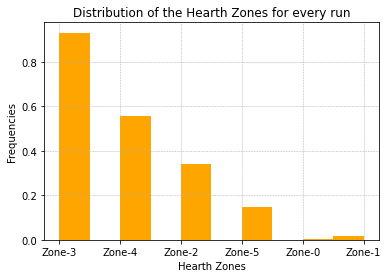

In [4]:
plt.hist(train['y'], density = True, color = 'orange')
plt.grid( linestyle = '--', linewidth = 0.5)
plt.title("Distribution of the Hearth Zones for every run")
plt.xlabel("Hearth Zones")
plt.ylabel("Frequencies")

plt.show()

Then let's see the curve of a random run for the different features (standardized) to see if there is correlation between them

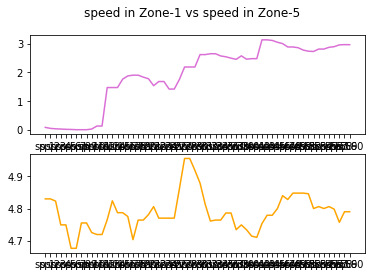

In [5]:
fig, (ax1, ax2) = plt.subplots( 2)
ax1.plot(train[train.loc[:,'y'] == 'Zone-1'].iloc[0,5:65], color = 'orchid')

ax2.plot(train[train.loc[:,'y'] == 'Zone-5'].iloc[0,5:65], color = 'orange')


fig.suptitle("speed in Zone-1 vs speed in Zone-5")
plt.show()

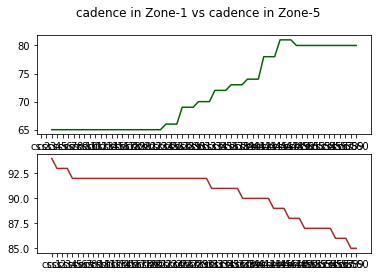

In [6]:
fig, (ax1, ax2) = plt.subplots( 2)
ax1.plot(train[train.loc[:,'y'] == 'Zone-1'].iloc[3,65:125], color = 'darkgreen')

ax2.plot(train[train.loc[:,'y'] == 'Zone-5'].iloc[0,65:125], color = 'brown')


fig.suptitle("cadence in Zone-1 vs cadence in Zone-5")
plt.show()

Here we can see the different speed and cadence in heart Zone-1 and heart Zone-5, the plots a really different in heart zone-5 the speed is higher and very irregular.
the cadence is higher in Zone-5 but decrese probably because the prof were tired.

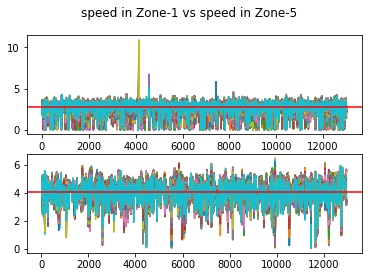

In [7]:
fig, (ax1, ax2) = plt.subplots( 2)
ax1.plot(train[train.loc[:,'y'] == 'Zone-2'].iloc[:,5:65])
ax1.axhline(y = np.mean(np.mean(train[train.loc[:,'y'] == 'Zone-2'].iloc[:,5:65])) , color = 'r')

ax2.plot(train[train.loc[:,'y'] == 'Zone-5'].iloc[:,5:65])
ax2.axhline(y = np.mean(np.mean(train[train.loc[:,'y'] == 'Zone-5'].iloc[:,5:65])) , color = 'r')
fig.suptitle("speed in Zone-1 vs speed in Zone-5")
plt.show()

We can see that in the Zone-5 the average speed (the red line) is higher

# Data engineering

Now it's time to clean the data! 

**The first step** is to fill the empty values (NaN). In order to do that, we use *fillna+bfill* function that fills the empty values with the next value (the one on the right)

In [8]:
#here we substitute the na 
train=train.fillna(method='bfill')
test=test.fillna(method='bfill')


train_X=train.drop(["id","y"],axis=1)
train_Y=train["y"]
test=test.drop(["id"],axis=1)

**First problem**: the column *month* contains unordered values. To keep this data without wasting them, we generate 12 columns (Jan,Feb,...,Dec) with binary values (0,1). 

i.e. if a run has been registered on May, its value *May* will be 1, and the other months will be 0.

In [9]:
#here we transform the categorical features
train_X=pd.get_dummies(train_X)
test=pd.get_dummies(test)

#let's check the dimension
print(train_X.shape)
print(test.shape)

(12997, 257)
(6995, 257)


**Standardization of the data:** we standardize the data in order to obtain faster and cleaner predictions.
    
We use StandardScaler function that standardizes the data in the following way:

$$x_i^{stand} = \frac{x_i-\mu}{\sigma}$$

In [10]:
#stardandization of the data
for col in range(3,244):
    scaler=StandardScaler()
    train_X.iloc[:,col]=scaler.fit_transform(np.array(train_X.iloc[:,col]).reshape(-1,1))
for col in range(3,244):
    
    scaler=StandardScaler()
    test.iloc[:,col]=scaler.fit_transform(np.array(test.iloc[:,col]).reshape(-1,1))

# Predictions

### The Model
After trying different approaches, the best model we found is the **Histogram Gradient Boosting Classifier**. 

We decided to try this algorithm because it is likely to perform well as GradientBoosting but is faster to train.\
The latter was a significant benefit because we did a fast GridSearch over many hyperparameters, which usually takes a lot of time.

The reason why Histogram Gradient Boosting is faster is because continuos variables are discretized into a fixed number of buckets, therefore the split which occurs in the single decision tree is quicker. 

The features we used to train the model are all standardized: *speed*, *cadence*, *fractional cadence* and *altitude*, the One-Hot encoded variables for *month* and *day* and the *from-start* variable. 
The hyperparameters we have chosen for Histogram Gradient Boosting are 200 as *max iterations number*, 0.01 as *learning rate* and min sample leaf as 5.\
With this configuration we have obtained a F1-Score of 0.72813.

In [11]:
#K-fold implementation: we split the train set into 10 folds
kfold=KFold(n_splits=10,shuffle=True,random_state=123)


##The GridSearch is commented because it's computationally heavy and we already found the best parameters
##Chosen parameters
#steps = [('hgb', HistGradientBoostingClassifier(random_state=123))]  
#pipeline = Pipeline(steps)  
#parameters = {'hgb__learning_rate':[0.01,0.1],'hgb__min_samples_leaf':[5],
#             "hgb__max_iter":[200]}

#Time for the GridSearch
#cv = GridSearchCV(pipeline, param_grid=parameters,cv=kfold,scoring="f1_macro")  
#cv.fit(train_X, train_Y)  

In [12]:
#best parameters
#print(cv.best_params_)

In [13]:
#Application of the Algorithm
hgb=HistGradientBoostingClassifier(random_state=123, learning_rate=0.01, min_samples_leaf=5, max_iter=400 )
scores=cross_val_score(hgb,train_X,train_Y,scoring="f1_macro",cv=kfold)
print(np.mean(scores))

0.5617360539988905


In [14]:
scores

array([0.5731521 , 0.5982306 , 0.54365917, 0.6302297 , 0.47973079,
       0.59737294, 0.5016504 , 0.49795483, 0.58775524, 0.60762476])

And now a quick last review to our train labels and predicted labels: in fact, we suppose that the distribution of the train labels and predictions is similar.\
So we expect that a good prediction gives us similar histograms to the train's.

In [15]:
hgb.fit(train_X,train_Y)
scores=hgb.predict(test)
results=pd.DataFrame()

test1=pd.read_csv("/kaggle/input/statistical-learning-sapienza-spring-2022/test.csv")
results["id"]=test1["id"]
results["target"]=scores

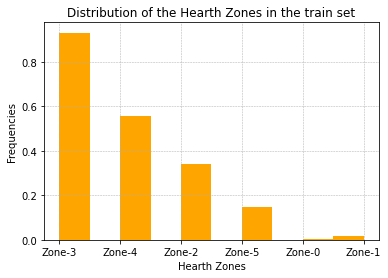

In [16]:
plt.hist(train_Y, density = True, color = 'orange')
plt.grid( linestyle = '--', linewidth = 0.5)
plt.title("Distribution of the Hearth Zones in the train set")
plt.xlabel("Hearth Zones")
plt.ylabel("Frequencies")

plt.show()

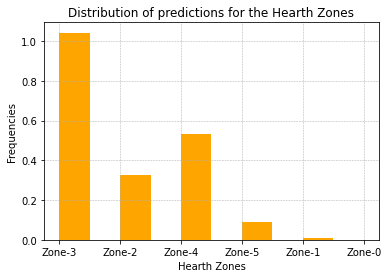

In [17]:
plt.hist(scores, density = True, color = 'orange')
plt.grid( linestyle = '--', linewidth = 0.5)
plt.title("Distribution of predictions for the Hearth Zones")
plt.xlabel("Hearth Zones")
plt.ylabel("Frequencies")

plt.show()

Ok, the frequencies of train-labels and predictions look similar! we can submit it

And... last but not least... Let's save the predictions

In [18]:
results.to_csv("hgb_200_001_2.csv",index=False)